---
title: "Reproducing Cui Xiang-Han et. al (2020)'s 'Fast radio bursts: do repeaters and non-repeaters originate in statistically similar ensembles?'"
subtitle: Is it possible that repeaters and non-repeaters have different mechanisms?
author: Murthadza Aznam
date: '2022-12-26'

---

:::{.callout-note}

 📌 Goal: This notebook tries to reproduce the results from [https://ui.adsabs.harvard.edu/abs/2021MNRAS.500.3275C/abstract](https://ui.adsabs.harvard.edu/abs/2021MNRAS.500.3275C/abstract). As stated in the paper, verbatim 
 
 > We investigate the statistical classifications for the two groups of samples **to see if the non-repeating and repeating FRBs have different origins** by employing Anderson–Darling (A–D) test and Mann–WhitneyWilcoxon (M–W–W) test

:::

In [1]:
#| echo: false
import warnings

warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as interpolate

## 0. Getting The Data

### 0.1 Source
The data underlying said article are available in the references below: 

1. Spitler et al. ([2016](https://www.nature.com/articles/nature17168)); 
2. CHIME/FRB Collaboration ([2019a](https://www.nature.com/articles/s41586-018-0864-x));
3. Kumar et al. ([2019](https://iopscience.iop.org/article/10.3847/2041-8213/ab5b08));
4. CHIME/FRB Collaboration ([2019b](https://iopscience.iop.org/article/10.3847/2041-8213/ab4a80));
5. Fonseca et al. ([2020](https://iopscience.iop.org/article/10.3847/2041-8213/ab7208)). 

Some data of FRBs are taken from the data base of FRBCAT, available at http://www.frbcat.org/.


#### 0.1.1 Non-Repeaters

However, I have not been able to effectively filter out repeater from the whole population in the FRBCAT Database.
Therefore, I joined it with FRBSTATS where the repeater population has been listed on its `utc` column rounded to the nearest second.

:::{.callout-warning}
## Deprecated

So I used the FRBSTATS^[https://www.herta-experiment.org/frbstats/] as a proxy with the described filters:

- `width` <= 35
- is not identified as `repeater`
- The FRB is observed between FRBCAT's minimum dan maximum `utc` datetime   
- `telescope` is also available in the FRBCAT catalogue, except 'CHIME/FRB'^[Even with the described filters, the CHIME/FRB telescope dominates the dataset making up >500 data points while it is not that prominent in FBRCAT and also the total data points is less than 100]
:::

Using the described filters, I have been able to obtain 88 data points.
It is close to the papers sample of 80 ~ 91^[The paper mentioned both numbers. The lower limit of 80 is mentioned in the conclusion but the upper limit of 91 is mentioned in the abstract. So I took it as a range instead.]

In [3]:
# Load FRBCAT Catalogue

frbcat = pd.read_csv("../data/raw/external/frbcat_20221227.csv", parse_dates=['utc']).rename(
    columns={
        'rop_sampling_time': 'sampling_time',
        'rop_bandwidth': 'bandwidth_MHz',
        'rop_centre_frequency': 'center_freq_MHz'
        })
frbcat['utc'] = frbcat['utc'].round('S')
frbcat = frbcat[frbcat['rmp_width'] <= 35]
frbcat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107 entries, 0 to 117
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   frb_name         107 non-null    object        
 1   utc              107 non-null    datetime64[ns]
 2   telescope        107 non-null    object        
 3   rop_raj          107 non-null    object        
 4   rop_decj         107 non-null    object        
 5   rop_gl           107 non-null    float64       
 6   rop_gb           107 non-null    float64       
 7   sampling_time    106 non-null    float64       
 8   bandwidth_MHz    107 non-null    float64       
 9   center_freq_MHz  107 non-null    float64       
 10  rmp_dm           107 non-null    float64       
 11  rmp_dm_error     107 non-null    float64       
 12  rmp_width        107 non-null    float64       
 13  rmp_snr          104 non-null    float64       
dtypes: datetime64[ns](1), float64(9), object(4

In [4]:
# Load FRBSTATS catalogue and do appropriate filter

# A separate list is used because FRBCAT uses a different name
frbstats_telescope_names_available_in_frbcat = ['Parkes', 'Arecibo', 'Pushchino', 'FAST', 'DSA', 'CHIME', 'WSRT/Apertif', 'UTMOST', 'VLA', 'GBT', 'ASKAP']
frbstats_float_columns = ['l', 'b', 'frequency', 'dm', 'flux', 'width', 'fluence', 'snr', 'redshift']

repeaters_samples = pd.read_csv('../data/raw/external/FRBSTATS2022-11-23_repeaters.csv', index_col=0)
frbstats = pd.read_csv('../data/raw/external/FRBSTATS2022-11-23_population.csv', 
    parse_dates=['utc'], 
    dtype={telescope: float for telescope in frbstats_telescope_names_available_in_frbcat},
    na_values=["-"]
    )
frbstats['utc'].round('S')
# Label repeaters
frbstats["repeater"] = False
frbstats.loc[frbstats["frb"].isin(repeaters_samples["samples"]),"repeater"] = True

# !! Filter is deprecated
# selected_data = frbstats[
#     (frbstats['repeater'] == False) & 
#     (frbstats["width"] <= 35) &
#     (frbstats["telescope"].isin(frbstats_telescope_names_available_in_frbcat)) &
#     (frbstats['telescope'] != 'CHIME') &
#     (frbstats["utc"].between(frbcat["utc"].min(), frbcat["utc"].max()))
#     ]

selected_data = pd.merge(frbcat[['utc', 'sampling_time', 'bandwidth_MHz', 'center_freq_MHz', 'rmp_width']], frbstats[frbstats['repeater'] == False], on='utc')

# Handle NaN values
selected_data.loc[selected_data['width'].isna(), ['width']] = selected_data['rmp_width']
selected_data.loc[selected_data['sampling_time'].isna(), ['sampling_time']] = 0

selected_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84 entries, 0 to 83
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   utc                84 non-null     datetime64[ns]
 1   sampling_time      84 non-null     float64       
 2   bandwidth_MHz      84 non-null     float64       
 3   center_freq_MHz    84 non-null     float64       
 4   rmp_width          84 non-null     float64       
 5   frb                84 non-null     object        
 6   mjd                84 non-null     float64       
 7   telescope          84 non-null     object        
 8   ra                 84 non-null     object        
 9   dec                84 non-null     object        
 10  l                  84 non-null     float64       
 11  b                  84 non-null     float64       
 12  frequency          84 non-null     float64       
 13  dm                 84 non-null     float64       
 14  flux        

In order the accept that both these data describe the same sample, I plotted the overlap between our selected data and the original FRBCAT data.

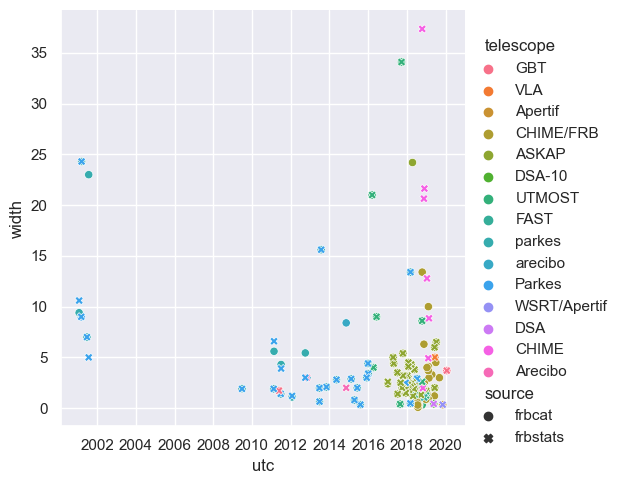

In [5]:
frbcat_ = frbcat.rename(columns={'frb_name':'frb','rop_raj': 'ra', 'rop_decj': 'dec', 'rop_gb': 'b', 'rop_gl': 'l', 'rmp_width': 'width', 'rmp_dm': 'dm', 'rmp_snr': 'snr'})
frbcat_.loc[:, ['source']] = 'frbcat'
frbstats_ = selected_data[['frb', 'utc', 'telescope', 'ra', 'dec', 'l', 'b', 'dm', 'width', 'snr']]
frbstats_.loc[:, ['source']] = 'frbstats'
frbpopulation_merged = pd.concat([frbcat_, frbstats_])

sns.relplot(data=frbpopulation_merged, x='utc', y='width', style='source', hue='telescope')

#### 0.1.2 Repeaters

Data on repeaters are easy to obtain. 
The authors are kind enough to provide table on all 20 samples used in the study.

![](xiang-han2020-table1.png)

In [6]:
xianghan = pd.read_csv('../data/raw/external/XiangHan2020_ensemble-repeaters.csv')

In [7]:
#| echo: false
from IPython.display import Markdown

Markdown(xianghan.to_markdown())

|    |   No. | Sources            |   Observed width (ms) |   Intrinsic width (ms) |   Flux density (Jy) |   Fluence (Jy ms) |   Distance (Gpc) | Refs.    |
|---:|------:|:-------------------|----------------------:|-----------------------:|--------------------:|------------------:|-----------------:|:---------|
|  0 |     1 | FRB121102.J000+00  |                  4.82 |                   4.78 |                0.25 |             0.372 |             1.61 | (1)      |
|  1 |     2 | FRB180814.J0422+73 |                 22.57 |                  23.43 |              nan    |            22.57  |             0.39 | (2)(3)   |
|  2 |     3 | FRB171019.J000+00  |                  4.62 |                   4.08 |              nan    |           101.54  |             1.89 | (4)      |
|  3 |     4 | FRB180916.J0158+65 |                  5.27 |                   5.16 |                2.08 |             1.62  |             0.58 | (5)      |
|  4 |     5 | FRB181030.J1054+73 |                  1.01 |                   0.1  |                3.15 |             4.75  |             0.24 | (5)      |
|  5 |     6 | FRB181128.J0456+63 |                  5.9  |                   5.8  |                0.4  |             3.45  |             1.14 | (5)      |
|  6 |     7 | FRB181119.J12+65   |                  3.49 |                   3.33 |                0.43 |             1.77  |             1.42 | (5)      |
|  7 |     8 | FRB190116.J1249+27 |                  2.75 |                   2.53 |                0.35 |             1.8   |             1.9  | (5)      |
|  8 |     9 | FRB181017.J1705+68 |                 16.8  |                  16.73 |                0.4  |             8.5   |             6.97 | (5)      |
|  9 |    10 | FRB190209.J0937+77 |                  6.55 |                   6.46 |                0.5  |             1.25  |             1.66 | (5)      |
| 10 |    11 | FRB190222.J2052+69 |                  2.71 |                   2.48 |                1.65 |             5.45  |             1.64 | (5)      |
| 11 |    12 | FRB190208.J1855+46 |                  1.11 |                   0.14 |                0.5  |             1.7   |             2.35 | (6)      |
| 12 |    13 | FRB180908.J1232+74 |                  3.83 |                   3.7  |                2.9  |             0.5   |             0.62 | (6)      |
| 13 |    14 | FRB190604.J1435+53 |                  2.1  |                   1.78 |                0.75 |             8.3   |             2.42 | (6)      |
| 14 |    15 | FRB190212.J18+81   |                  3.1  |                   2.93 |                0.75 |             2.75  |             1.05 | (6)      |
| 15 |    16 | FRB190303.J1353+48 |                  3.2  |                   3.04 |                0.47 |             2.67  |             0.77 | (6)      |
| 16 |    17 | FRB190417.J1939+59 |                  4.5  |                   4.2  |                0.53 |             3.1   |             7.4  | (6)      |
| 17 |    18 | FRB190117.J2207+17 |                  2.74 |                   2.53 |                1    |             6.36  |             1.49 | (6)      |
| 18 |    19 | FRB190213.J02+20   |                  7    |                   6.9  |                0.5  |             1.8   |             2.91 | (6)      |
| 19 |    20 | FRB190907.J08+46   |                  2.18 |                   1.92 |                0.3  |             2.03  |             1.07 | (6)      |

## 1.0 Preprocessing

### 1.1 Parameters

We first process our data to uncover these parameters:

1. Pulse width
2. Radio Luminosity

#### 1.1.1 Pulse Width
Since the pulse width in the FRBCAT is the observed width, which is easily affected by dispersion, to study the pulse width more accurately, we need to introduce the intrinsic width that is estimated by equation:
$$
t_i = \sqrt{t^2_\text{obs} − t^2_\text{DM} − t^2_s}
$$
In the above formula, $t_i(t_\text{obs})$ is the intrinsic width (observed width), with $t_s$ being the sampling time that depends on the instrument, and $t_\text{DM}$ is the dispersion smearing time-scale as calculated in the following: 
$$
t_\text{DM} = 8.3 \times 10^{−3} \text{DM}\frac{\Delta ν_\text{MHz}}{ν^3_\text{GHz}} ms,
$$
where DM is the dispersion measure, $\Delta ν_\text{MHz}$ is the channel bandwidth in the unit of MHz, and $ν_\text{GHz}$ is the central frequency in the unit of GHz. 
Therefore, the pulse width in the following text represents the intrinsic width.

In [8]:
def dispersion_smearing_timescale(dispersion_measure, bandwidth_MHz, center_freq_GHz) -> float:
    return 8.3e-6 * dispersion_measure * (bandwidth_MHz / center_freq_GHz**3)

def instrinsic_width(observed_width, sampling_time, dispersion_measure, bandwidth_MHz, center_freq_GHz) -> float:
    return np.sqrt(abs((observed_width**2 - dispersion_smearing_timescale(dispersion_measure, bandwidth_MHz, center_freq_GHz)**2 - sampling_time**2)))

In [9]:
selected_data.loc[:, 'intrinsic_width_ms'] = instrinsic_width(
    selected_data['width'], 
    selected_data['sampling_time'], 
    selected_data['dm'], 
    selected_data['bandwidth_MHz'], 
    selected_data['center_freq_MHz']*0.001)

In [10]:
frbcat.loc[:, 'intrinsic_width_ms'] = instrinsic_width(
    frbcat['rmp_width'],
    frbcat['sampling_time'],
    frbcat['rmp_dm'],
    frbcat['bandwidth_MHz'],
    frbcat['center_freq_MHz']*0.001
)

#### 1.1.2 Radio Luminosity

## 2.0 Statistical Test

### 2.1 Anderson--Darling Test

An Anderson--Darling test (A-D test) is used to measure the likelihood that a sample follows a certain distribution.

In [11]:
xianghan['Intrinsic width (ms)'].mean(), xianghan['Intrinsic width (ms)'].std()

(5.101000000000001, 5.542362122302804)

In [25]:
from scipy.special import erf

xianghan['z_score'] = (xianghan['Intrinsic width (ms)'] - xianghan['Intrinsic width (ms)'].mean())/xianghan['Intrinsic width (ms)'].std()
xianghan['pdf'] = (1/(xianghan['Intrinsic width (ms)'].std()*np.sqrt(2*np.pi)))*np.exp(-0.5*(xianghan['z_score']**2))
sorted_pdf = xianghan.sort_values(by='Intrinsic width (ms)')['pdf']
xianghan['erf_gauss'] = erf((xianghan['z_score']/np.sqrt(2)))
xianghan['cdf'] = 0.5*(1+xianghan['erf_gauss'])
xianghan['survival_func'] = 1 - xianghan['cdf']
S_ = []
N = len(xianghan['Intrinsic width (ms)'])
for i, val in enumerate(xianghan['Intrinsic width (ms)'].sort_values(), start=1):
    val_1 = ((2*i)-1)*np.log(xianghan['cdf'].sort_values()[i-1])
    val_2 = ((2*N) - (2*i) + 1)*np.log(xianghan['cdf'].sort_values()[i-1])
    # val = np.log(xianghan['cdf'].sort_values()[i-1]) + np.log(1-xianghan['survival_func'].sort_values(ascending=False)[i-1])
    S_.append(val_1 + val_2)
coeff = 1/N
A_2 = -len(xianghan['Intrinsic width (ms)']) - coeff*sum(S_)
# sns.relplot(xianghan, x='Intrinsic width (ms)', y='survival_func', kind='line')
# sns.relplot(xianghan, x='Intrinsic width (ms)', y='cdf', kind='line')
# sns.ecdfplot(selected_data[:int(len(selected_data['intrinsic_width_ms'])/2)], x='intrinsic_width_ms')
# sns.ecdfplot(selected_data[int(len(selected_data['intrinsic_width_ms'])/2):], x='intrinsic_width_ms')
# sns.ecdfplot(frbcat, x='intrinsic_width_ms')
A_2*(1+(4/N)-(25/(N**2)))

18.309025157888357

In [13]:
xianghan['survival_func']

0     0.523093
1     0.000471
2     0.573079
3     0.495753
4     0.816557
5     0.449819
6     0.625341
7     0.678634
8     0.017944
9     0.403150
10    0.681859
11    0.814635
12    0.599781
13    0.725481
14    0.652364
15    0.645003
16    0.564570
17    0.678634
18    0.372745
19    0.716997
Name: survival_func, dtype: float64

In [14]:
cdf = sorted_pdf.cumsum()

In [15]:
def CDF(x, y):
    func = interpolate.interp1d(x, y)
    cdf_at_x = list()
    for i, k in enumerate(y):
        if i == 0:
            cdf_at_x.append(k)
        else:
            cdf_at_x.append(k + cdf_at_x[i-1])
    return np.array(cdf_at_x)/max(cdf_at_x)

def SurvivalFunc(cdf: np.ndarray) -> np.ndarray:
    return 1-cdf

cdf = CDF(xianghan['Intrinsic width (ms)'], xianghan['Intrinsic width (ms)'].sort_values())
sf = SurvivalFunc(cdf)
S_ = list()
for i, cdf_ in enumerate(cdf, start=1):
    coeff = ((2*i)-1)/len(cdf)
    val = np.log(cdf_) + np.log(sf[i-1])
    if val == np.infty or val == -np.infty:
        val = 0
    S_.append(coeff*val)
-len(cdf)-sum(S_)


12.235782299490147

In [16]:
from scipy.stats import anderson, shapiro, kstest, norm

anderson(xianghan['Intrinsic width (ms)'], dist='norm')

AndersonResult(statistic=2.386069262367567, critical_values=array([0.506, 0.577, 0.692, 0.807, 0.96 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [17]:
anderson(frbcat['intrinsic_width_ms'].dropna(), dist='norm')

AndersonResult(statistic=8.80968649682626, critical_values=array([0.556, 0.634, 0.76 , 0.887, 1.055]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [18]:
from scipy.stats import mannwhitneyu

mannwhitneyu(xianghan['Intrinsic width (ms)'][:10], xianghan['Intrinsic width (ms)'][10:])

MannwhitneyuResult(statistic=75.5, pvalue=0.05868668127026372)

In [19]:
exclude = [2, 12, 20]
# 2, 19, 7  = 1.42809
# 2, 12, 20 = 1.43080

sample = xianghan[xianghan['No.'].isin(exclude) == False]

print(anderson(sample['Intrinsic width (ms)'], dist='norm'))
print(sample['Sources'])

AndersonResult(statistic=1.4308038840282826, critical_values=array([0.501, 0.571, 0.685, 0.799, 0.951]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
0      FRB121102.J000+00
2      FRB171019.J000+00
3     FRB180916.J0158+65
4     FRB181030.J1054+73
5     FRB181128.J0456+63
6       FRB181119.J12+65
7     FRB190116.J1249+27
8     FRB181017.J1705+68
9     FRB190209.J0937+77
10    FRB190222.J2052+69
12    FRB180908.J1232+74
13    FRB190604.J1435+53
14      FRB190212.J18+81
15    FRB190303.J1353+48
16    FRB190417.J1939+59
17    FRB190117.J2207+17
18      FRB190213.J02+20
Name: Sources, dtype: object


In [20]:
a = xianghan.rename(columns={'Intrinsic width (ms)':'intrinsic_width_ms', 'Sources': 'frb'})[['intrinsic_width_ms', 'frb']]
b = frbcat.rename(columns={'frb_name':'frb'})[['intrinsic_width_ms', 'frb']]
a['source'] = 'repeater'
b['source'] = 'non_repeater'
together = pd.concat([a,b])[['intrinsic_width_ms', 'source']]
together

,intrinsic_width_ms,source
0,4.780000,repeater
1,23.430000,repeater
2,4.080000,repeater
3,5.160000,repeater
4,0.100000,repeater
...,...,...
113,22.975652,non_repeater
114,6.961764,non_repeater
115,24.254762,non_repeater
116,8.993350,non_repeater


In [21]:
anderson(selected_data['width'], dist='norm')

AndersonResult(statistic=11.225411788944001, critical_values=array([0.552, 0.628, 0.754, 0.879, 1.046]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [22]:
# Luminosity

import scipy

Omega_m = 0.315
Omega_Lambda = 0.685
H_0 = 67.4 * 1000 * 100  # cm s^-1 Mpc^-1
c = 29979245800  # cm s^-1
Hubble_distance = c / H_0  # Mpc

def comoving_distance_at_z(z):  # Mpc
    zp1 = 1.0 + z
    h0_up = np.sqrt(1 + Omega_m / Omega_Lambda) * scipy.special.hyp2f1(
        1 / 3, 1 / 2, 4 / 3, -Omega_m / Omega_Lambda
    )
    hz_up = (
        zp1
        * np.sqrt(1 + Omega_m * zp1**3 / Omega_Lambda)
        * scipy.special.hyp2f1(1 / 3, 1 / 2, 4 / 3, -Omega_m * zp1**3 / Omega_Lambda)
    )
    h0_down = np.sqrt(Omega_Lambda + Omega_m)
    hz_down = np.sqrt(Omega_Lambda + Omega_m * zp1**3)
    return Hubble_distance * (hz_up / hz_down - h0_up / h0_down)


def luminosity_distance_at_z(z):  # Mpc
    return (1.0 + z) * comoving_distance_at_z(z)

def redshift_from_distance(distance):
    return distance*H_0/c

def brightness_temperature(flux, width, frequency, redshift) -> pd.DataFrame:
    return (
        1.1e35 * flux
        * (width * 1000) ** (-2)
        * (frequency / 1000) ** (-2)
        * (luminosity_distance_at_z(redshift) / 1000) ** 2
        / (1 + redshift)
    )

<AxesSubplot: xlabel='luminosity', ylabel='Count'>

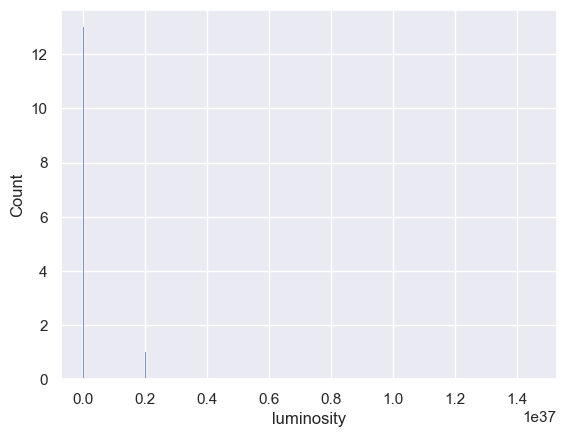

In [23]:
xianghan['luminosity'] = brightness_temperature(xianghan['Flux density (Jy)'], xianghan['Intrinsic width (ms)'], xianghan['Observed width (ms)'],redshift_from_distance(xianghan['Distance (Gpc)']*1000))

sample = xianghan.dropna()

sns.histplot(sample['luminosity'])